In [5]:
!ls -la

total 1040
drwxr-xr-x 1 root root    4096 May 25 08:15 .
drwxr-xr-x 1 root root    4096 May 25 08:14 ..
drwxr-xr-x 4 root root    4096 May 23 13:24 .config
drwxr-xr-x 1 root root    4096 May 23 13:25 sample_data
-rw-r--r-- 1 root root 1048576 May 25 08:15 sensor.csv


In [6]:
!pip install catboost

In [7]:
import pandas as pd
import numpy as np
import  seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.preprocessing import PowerTransformer, LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold


import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Reading Data

In [8]:
# load csv file
df = pd.read_csv("sensor.csv")

In [9]:
# check rows and columns of the datset
df.shape

(975, 171)

In [10]:
df.columns

Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=171)

In [11]:
df["class"].value_counts()

class
neg    519
pos    456
Name: count, dtype: int64

## Insight:
- Data is imbalanced.

In [12]:
# define numerical columns and catergorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print(f"we have {len(numeric_features)} numerical features: {numeric_features}")
print(f"We have {len(categorical_features)} categorical features: {categorical_features}")

we have 170 numerical features: ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000',

#### As this is a sensor data. Interpretation of the data is not required

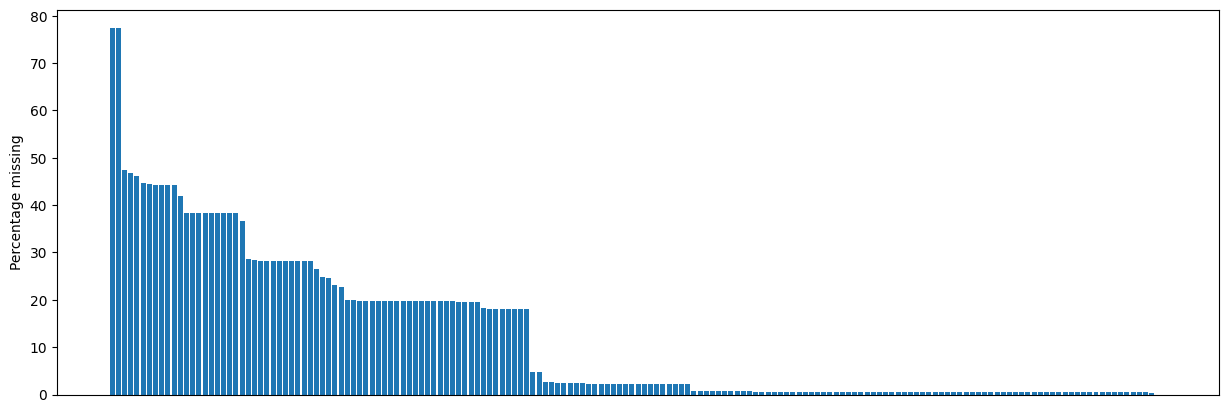

In [13]:
# Checking missing values
# plot missing values count for each column
fig, ax = plt.subplots(figsize=(15,5))
missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index,missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

In [14]:
# Droping columns which has more than 70% of missing values
dropcols = missing[missing[0]> 70]
dropcols

,0
cr_000,77.435897
ab_000,77.333333


In [15]:
df.drop(list(dropcols.index), axis=1, inplace= True)

In [16]:
df.shape

(975, 169)

In [17]:
# Check the total percentage of missing values of the full dataset after dropping columns with more than 70% of missing values
missing_values_count = df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percentage of the data that is missing
print(f"Percentage of total missing cells in the data {(total_missing / total_cells) * 100}%")

Percentage of total missing cells in the data 11.538764982551966%


Positive: 456 
Negative : 519


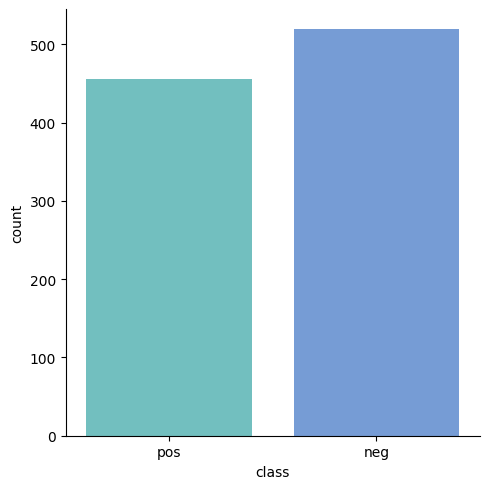

In [18]:
# Visualization of unique values in Target varibales
pos = df[df['class']== 'pos'].shape[0]
neg = df[df['class'] == 'neg'].shape[0]

print(f"Positive: {str(pos)} \nNegative : {str(neg)}")
sns.catplot(data=df, x="class", kind = "count", palette = "winter_r", alpha = 0.6)
plt.show()

- <span style="color:red;">**Report:**</span>
    - The Target classes are highly imblanced
    - Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative class (Majority class) very large compared to that of the positive class (Minority class).
    - If the imbalanced data is not treated beforehand, then thos will degrade the performance of the classifier model.
    - Hence we should handle imbalanced data with certain methods.

### How to handle Imbalanced data
- Resampling data is one of the most commonly performed approaches to deal with an imbalanced dataset. They are broadlt two types of methods for this
    - Undersampling
    - Oversampling
- In most cases oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information.
- **SMOTE:** Synthetic Minority Oversampling Technique
    - SMOTE is an oversampling technique where the synthetic samples are generated for the minority class.
- Hybridization technniques involve combing both undersampling and oversampling techniques. This is done to optimize the performance of classifier models for the samples created as part of these techniques.
- It only duplicates the data and it won't add new information. Hence we look at some different techniques.

### Create Functions for model training and evaluation

In [19]:
def evaluate_clf(true, predicted):
    """
    This function takes true values and predicted values
    Returns: Accuracy, F1-Score, Precission, Recall, Roc-auc Score
    """
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    precission = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)
    return acc, f1, precission, recall, roc_auc

In [20]:
# Create cost of the model as per data description
def total_cost(y_true, y_pred):
    """
    This function takes y_true, y_predicted and prints Total cost due to misclassification
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10 * fp + 500 * fn
    return cost

In [21]:
# Create a function which evaluate models and return a report
def evaluate_models(X, y, models):
    """
    This function takes X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    """

    # seperate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

    cost_list = []
    models_list = []
    accuracy_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train the model

        # Make prediction
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1, model_train_precision,\
        model_train_recall, model_train_rocauc_score = evaluate_clf(y_train, y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)

        # Testing set performance
        model_test_accuracy, model_test_f1, model_test_precision,\
        model_test_recall, model_test_rocauc_score = evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print("Model performance for Training set")
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print("- F1 score: {:.4f}".format(model_train_f1))
        print("- Precision: {:.4f}".format(model_train_precision))
        print("- Recall: {:.4f}".format(model_train_recall))
        print("- Roc Auc Score: {:.4f}".format(model_train_rocauc_score))
        print("- COST: {}".format(train_cost))

        print("-"*30)

        print("Model performance for Test set")
        print("- Accuracy: {:.4f}".format(model_test_accuracy))
        print("- F1 score: {:.4f}".format(model_test_f1))
        print("- Precision: {:.4f}".format(model_test_precision))
        print("- Recall: {:.4f}".format(model_test_recall))
        print("- Roc Auc Score: {:.4f}".format(model_test_rocauc_score))
        print("- COST: {}".format(test_cost))

        cost_list.append(test_cost)

        print("="*30)
        print("\n")

    report = pd.DataFrame(list(zip(models_list, cost_list)), columns = ['Models Name', 'Cost']).sort_values(by=['Cost'])

    return report



In [1]:
df.columns

NameError: name 'df' is not defined

In [ ]:
# Plot distribution of all independent numerical varibales
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O'] # After columns dropped, creating again

plt.figure(figsize=(15, 100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.histplot(x = df[col], color="indianred",kde = True)
    plt.xlabel(col, weight ="bold")
    plt.tight_layout()

- <span style="color:red"> **Report:** </span>
    - As per the above plots most of the features are not normally distributed.
    - Transformation of data is not of prime importance since it is a classification problem.
    - Interpreting each and evry column is not necessary as this is sensor data

### Evaluate model on Different experients

In [ ]:
X = df.drop('class', axis = 1)
y = df['class']

In [ ]:
# Manually encoding target values
y = y.replace({'pos': 1, 'neg': 0})

## Experient 1
- KNN Imputer for null values

### Why Robust scaler and not Standard scaler?
- Scaling the data using Robust Scaler
- Since most of the independent varibales are not normally distributed. So we can not use **Standardscaler**

### Why Robust scaler and not Minmax
- Because most of the fatures has outliers. So Minmax will scale data accoridng to Max values which is outlier
- This scaler removes the median and scales the data according to the quantile range (defautls to **IQR**: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quantile (75th quantile)

In [ ]:
# Fit with Robust scaler for KNN best k-selection experminet
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

### Why KNN Imputer
- KNNIMputer by scikit-learn is a widely used method to impute missing values. It is widely being observed as a replacement for traditional imputation techniques.
- KNNImputer helps to impute missing values present in the observation by finding the nearest neighbors with the Euclidean distance matrix.
- Here we iterates through different K values and get accuracy and choose best K values.

### Finding the optimal n_neighbour value for KNN Imputer

In [ ]:
results = []
# define imputer
imputer = KNNImputer(n_neighbors=5, weights = "uniform", metric="nan_euclidean")
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring="accuracy", cv = 2, n_jobs= -1)
    results.append(scores)
    print('n_neighbors=%s || accuracy (%.4f)' % (s, mean(scores)))

- We can observe n_neighbors=3 able to produce hoghest accuracy

### Pipeline for KNN imputer

In [ ]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the KNN imputer with selected K-value
knn_pipeline = Pipeline(
    stpes=[
        ('imputer', KNNImputer(n_neighbors=3)),
        ('RobustScaler', RobustScaler())
    ]
)

In [ ]:
X_knn = knn_pipeline.fit_transform(X)